# Unemployment ARIMA Model - Training (1997-2020), Training (2021-2023)

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import gdown

In [2]:
# 2. Load the dataset
url = 'https://drive.google.com/uc?id=1iJ-fXzt1maahR-_YH36yFBrHQ7lYQWf9'

# Download the file
output = 'data_unemployment.csv'
gdown.download(url, output, quiet=False)

# Check the content of the downloaded file
with open(output, 'r') as file:
    content = file.read()
    print("File content preview:")
    print(content[:500])

# Load the CSV file into a pandas DataFrame
try:
    data_unemployment = pd.read_csv(output, delimiter=',')
    print(data_unemployment.head())
except pd.errors.ParserError as e:
    print("Error parsing CSV file:", e)

Downloading...
From: https://drive.google.com/uc?id=1iJ-fXzt1maahR-_YH36yFBrHQ7lYQWf9
To: d:\OneDrive (Personal)\OneDrive\~ TMU 2023\CIND 820 - Big Data Analytics Project\06 - Initial Results & Code (10%)\data_unemployment.csv
100%|██████████| 799k/799k [00:00<00:00, 4.82MB/s]


File content preview:
ref_date,geo,labour_force,sex,age_group,uom,value,industry_classification,naics,sex_binary,age_group_numeric,geo_code,date_ordinal
1997,newfoundland and labrador,unemployment rate,males,25 to 54 years,Percentage,12.1,"fishing, hunting and trapping",114,1,1,210,729025
1998,newfoundland and labrador,unemployment rate,males,25 to 54 years,Percentage,9.0,"fishing, hunting and trapping",114,1,1,210,729390
1999,newfoundland and labrador,unemployment rate,males,25 to 54 years,Percentage,9.4,"fishing, h
   ref_date                        geo       labour_force    sex  \
0      1997  newfoundland and labrador  unemployment rate  males   
1      1998  newfoundland and labrador  unemployment rate  males   
2      1999  newfoundland and labrador  unemployment rate  males   
3      2000  newfoundland and labrador  unemployment rate  males   
4      2001  newfoundland and labrador  unemployment rate  males   

        age_group         uom  value        industry_classification 

In [3]:
# 3. Preprocess Data
# Convert 'ref_date' to datetime with year format
data_unemployment['ref_date'] = pd.to_datetime(data_unemployment['ref_date'], format='%Y')

# Set 'ref_date' as index
data_unemployment.set_index('ref_date', inplace=True)

# Ensure only numeric columns are included
numeric_cols = data_unemployment.select_dtypes(include=[np.number]).columns
data_unemployment = data_unemployment[numeric_cols]

# Aggregate data by year to reduce noise
data_annual = data_unemployment.resample('Y').mean()

# Select the 'value' column for ARIMA modeling
unemployment_rate = data_annual['value']

# Split the data into training and testing sets based on the date
train_data = unemployment_rate[unemployment_rate.index < '2021']
test_data = unemployment_rate[unemployment_rate.index >= '2021']

In [4]:
# 4. Define Cross-Validation Procedure
tscv = TimeSeriesSplit(n_splits=5)

In [5]:
# 5. Perform Cross-Validation
cv_mse_scores = []
for train_index, val_index in tscv.split(train_data):
    train_cv, val_cv = train_data.iloc[train_index], train_data.iloc[val_index]
    
    # Fit the ARIMA model
    model = ARIMA(train_cv, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=len(val_cv))
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(val_cv, forecast)
    cv_mse_scores.append(mse)

print('Cross-Validation Mean Squared Error:', np.mean(cv_mse_scores))

c:\Users\nesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\nesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cross-Validation Mean Squared Error: 0.7502746838927979


In [6]:
# 6. Train Final Model on Entire Training Set and Forecast on Test Set
final_model = ARIMA(train_data, order=(1, 1, 1))
final_model_fit = final_model.fit()

# Forecast
final_forecast = final_model_fit.forecast(steps=len(test_data))
forecast_index = test_data.index

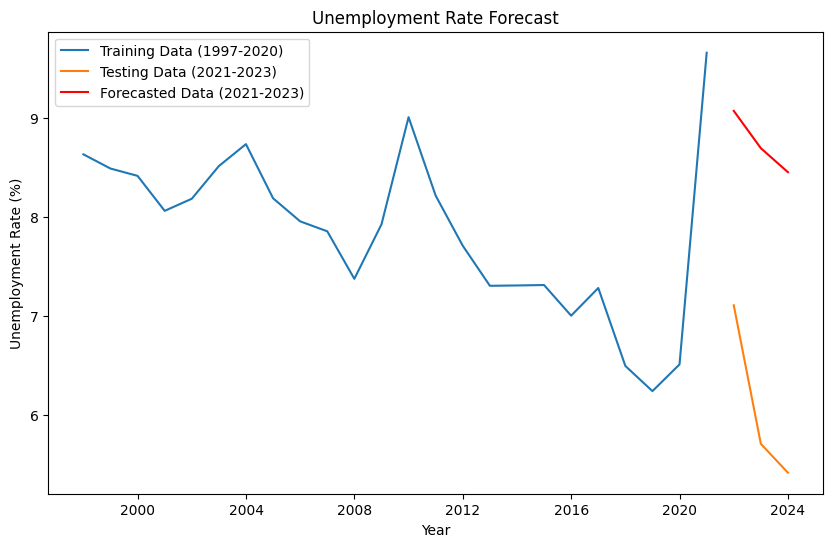

Final Model Mean Squared Error: 7.2992481838765855


In [7]:
# 7. Visualize the Data
# Visualize the Forecasted Data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data (1997-2020)')
plt.plot(test_data, label='Testing Data (2021-2023)')
plt.plot(forecast_index, final_forecast, label='Forecasted Data (2021-2023)', color='red')
plt.title('Unemployment Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.show()

# Calculate Mean Squared Error for the final model
final_mse = mean_squared_error(test_data, final_forecast)
print('Final Model Mean Squared Error:', final_mse)
